In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.datasets import make_circles, make_moons

import scipy

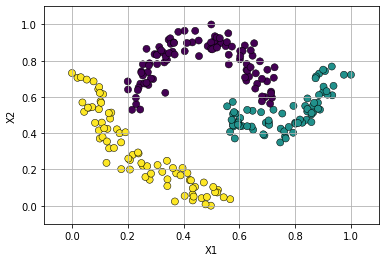

In [2]:
np.random.seed(249) ## 148, 249

xxc, yc = make_circles(n_samples=600, factor=.5,
                                      noise=.09)
idx = yc==0
xxc = xxc[idx]
yc = yc[idx]

idx = (xxc[:,0]+xxc[:,1]<-1)
xxc = xxc[idx]
yc = yc[idx]


xxm, ym = make_moons(n_samples=200, noise=.15)
xxm = xxm/2 - 0.2

msk0 = np.bitwise_and(ym==1 ,xxm[:, 0] > 0)
msk1 = ym==0
msk = msk0 | msk1
xxm = xxm[msk]
ym = ym[msk]

xx = np.concatenate((xxm, xxc), axis=0)
y = np.concatenate((ym, yc+2), axis=0)

## MinMax Normalization
x1 = xx[:,0]
x2 = xx[:,1]
x1 = (x1-x1.min())/(x1.max()-x1.min())
x2 = (x2-x2.min())/(x2.max()-x2.min())
xx = np.column_stack((x1,x2))

%matplotlib inline
plt.scatter(x1, x2, c=y, s=50, edgecolors='k', lw=0.5)

(x1min, x1max) = -0.1, 1.1
plt.xlim((x1min, x1max))
plt.ylim((x1min, x1max))
plt.xlabel("X1")
plt.ylabel('X2')
plt.grid()

In [9]:
def plot_results(X, Y_, means, covariances, alpha=0.2, covar_scale = [0.5, 1, 2] ):
    ax = plt.subplot(1, 1, 1)
    for i, (mean, covar) in enumerate(zip(
            means, covariances)):
        v, w = np.linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / np.linalg.norm(w[0])
        # as the DP will not use every component it has access to
        # unless it needs it, we shouldn't plot the redundant
        # components.
        if not np.any(Y_ == i):
            continue
        sctp = plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], marker='.')

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        c = sctp.get_facecolor()[0]
    
        for scale in covar_scale:
            ell = matplotlib.patches.Ellipse(mean, v[0]*scale, v[1]*scale, 180. + angle, color=c)
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(alpha/scale)
            ax.add_artist(ell)

## GMM model

In [50]:
# https://towardsdatascience.com/gaussian-mixture-models-implemented-from-scratch-1857e40ea566
# https://towardsdatascience.com/how-to-code-gaussian-mixture-models-from-scratch-in-python-9e7975df5252
class GMM:
    def __init__(self, n_components):
        self.n_components = n_components
        self.pi = np.array([1/self.n_components for comp in range(self.n_components)])
        self.mean = None
        self.cov = None
        
    def multivariate_normal(self, X, mean, covariance):
        return scipy.stats.multivariate_normal.pdf(X, mean, covariance)
        
    def fit(self, X, num_iter=10000):
        new_X = np.array_split(X, self.n_components)
        self.mean = np.array([np.mean(x, axis=0) for x in new_X])
        self.cov = np.array([np.cov(x.T) for x in new_X])
        # Deleting the new_X matrix because we will not need it anymore
        del new_X
        
        for iteration in range(num_iter):

            ''' ----------------   E - STEP   ------------------ '''
            # Initiating the r matrix, everey row contains the probabilities
            r = np.empty((self.n_components, len(X)))
            for k in range(self.n_components):
                rk = self.pi[k] * self.multivariate_normal(X, self.mean[k], self.cov[k])
                r[k] = rk
            r = r/r.sum(axis=0, keepdims=True)
#             print(r.shape, r.sum(axis=0, keepdims=True).shape)
            # Calculating the N
            N = np.sum(r, axis=1)
            
            ''' ---------------   M - STEP   --------------- '''
            for k in range(self.n_components):
                self.mean[k] = (X*r[k].reshape(-1, 1)).sum(axis=0)/N[k]
                
            for k in range(self.n_components):
#                 self.cov[k] = np.cov(X.T, aweights=r[k], ddof=0)/N[k]
                self.cov[k] = np.cov(X.T, aweights=(r[k]/N[k]).flatten(), bias=True)
           
            self.pi = N/len(X)
        
            
    def predict(self, X, rescale=False):
        probas = np.zeros((len(X), self.n_components))
        for k in range(self.n_components):
            if rescale:
                probas[:, k] = self.pi[k] * self.multivariate_normal(X, self.mean[k], self.cov[k])
            else:
                probas[:, k] = self.multivariate_normal(X, self.mean[k], self.cov[k])
        return np.argmax(probas, axis=1)

In [51]:
gmm = GMM(3)

In [52]:
gmm.fit(xx)

In [53]:
gmmc = gmm.predict(xx, rescale=True)
gmmc

array([1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2,
       1, 1, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2,
       1, 2, 2, 2, 2, 1, 1, 2, 2, 2])

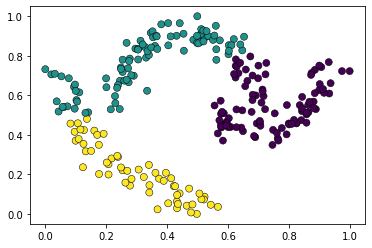

In [54]:
plt.scatter(x1, x2, c=gmmc, s=50, edgecolors='k', lw=0.5)

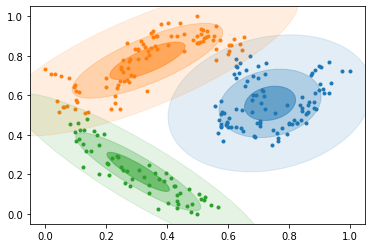

In [55]:
plot_results(xx, gmmc, gmm.mean, gmm.cov, alpha=0.25)

In [56]:
gmm.cov

array([[[ 0.01404165,  0.00285934],
        [ 0.00285934,  0.01501105]],

       [[ 0.03065429,  0.01791135],
        [ 0.01791135,  0.01798173]],

       [[ 0.02108397, -0.01824928],
        [-0.01824928,  0.01959311]]])

## Clustering

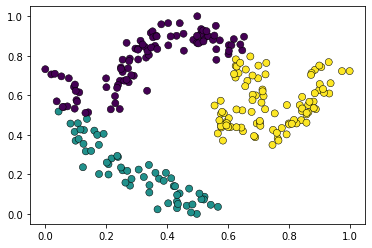

In [57]:
gmm_ = GaussianMixture(
    n_components=3)
gmmc_ = gmm_.fit_predict(xx)

plt.scatter(x1, x2, c=gmmc_, s=50, edgecolors='k', lw=0.5)

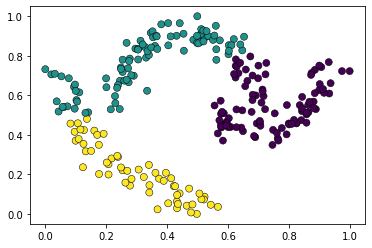

In [58]:
plt.scatter(x1, x2, c=gmmc, s=50, edgecolors='k', lw=0.5)

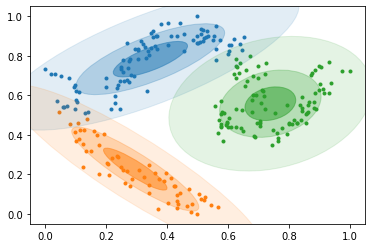

In [59]:
plot_results(xx, gmmc_, gmm_.means_, gmm_.covariances_, alpha=0.25)

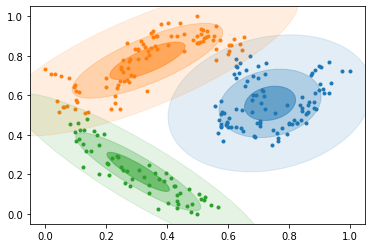

In [60]:
plot_results(xx, gmmc, gmm.mean, gmm.cov, alpha=0.25)

## GMM with gradient descent ?!